### Hierarchical classification training demo
Based on my previous work.
TODO: Switch to Guillaume's

In [1]:
import os
import random
from collections import defaultdict
from tempfile import NamedTemporaryFile
from urllib.parse import urljoin
from urllib.request import urlretrieve

import numpy as np
import torch
from hierarchical.base.integration import (MultiLevelResultCollector,
                                      hierarchical_dataloader_builder,
                                      hierarchical_model_builder,
                                      hierarchical_parse_class_index)
from hierarchical.base.loss import MultiLevelCrossEntropyLoss
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from torch import nn as nn
from tqdm.contrib.concurrent import thread_map
from tqdm.notebook import tqdm as TQDM

from mini_trainer.predict import ImageLoader

In [9]:
repo = "https://anon.erda.au.dk/share_redirect/btK3WIh4Md/rebalanced75_without_larvae/"

with NamedTemporaryFile(suffix = "txt") as tmpfile:
    urlretrieve(
        urljoin(repo, "folder_index.txt"),
        tmpfile.name
    )
    with open(tmpfile.name, "r") as f:
        file_index = [line.strip() for line in f.readlines()]

### Extract the class hierarchy from the directory structure

In [10]:
hierarchy = sorted(filter(lambda x : len(x) == 3, set(tuple(path.split("/")[:-1]) for path in TQDM(file_index, desc="Finding unique classes..."))))

Finding unique classes...:   0%|          | 0/1405516 [00:00<?, ?it/s]

Count the number of images per class (species)

In [11]:
counts = defaultdict(lambda : 0)

for path in TQDM(file_index, desc="Counting images per class..."):
    path_from_root = tuple(path.split("/")[:-1])
    if path_from_root in hierarchy:
        counts[path_from_root] += 1

Counting images per class...:   0%|          | 0/1405516 [00:00<?, ?it/s]

Filter species with less than 1000 images, and select 200 training images and 25 test images

In [12]:
more_than_1000 = set(cls for cls in hierarchy if counts[cls] >= 3000)
print(f'Number of classes with more than 1000 images: {len(more_than_1000)}')
print(f'Number of total images for selected classes: {sum(counts[cls] for cls in more_than_1000)}')
train_counts, test_counts = defaultdict(lambda : 0), defaultdict(lambda : 0)
train_images, test_images = [], []
for path in TQDM(file_index, desc="Allocating train/test images..."):
    path_from_root = tuple(path.split("/")[:-1])
    if not (path_from_root in more_than_1000):
        continue
    if train_counts[path_from_root] < 200:
        train_counts[path_from_root] += 1
        train_images.append(path)
    elif test_counts[path_from_root] < 25:
        test_counts[path_from_root] += 1
        test_images.append(path)
print(f'Number of training images: {len(train_images)}')
print(f'Number of test images: {len(test_images)}')

Number of classes with more than 1000 images: 172
Number of total images for selected classes: 735486


Allocating train/test images...:   0%|          | 0/1405516 [00:00<?, ?it/s]

Number of training images: 34400
Number of test images: 4300


### Download train/test images

In [13]:
train_dir = os.path.join("hierarchical", "train")
test_dir = os.path.join("hierarchical", "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def _download_one(f, d, override=False):
    lpath = os.path.join(d, f)
    if os.path.exists(lpath):
        if override:
            os.remove(lpath)
        else:
            return
    os.makedirs(os.path.dirname(lpath), exist_ok=True)
    urlretrieve(
        urljoin(repo, f),
        lpath
    )

thread_map(lambda x : _download_one(x, test_dir), test_images, tqdm_class=TQDM, desc="Downloading test images...")
thread_map(lambda x : _download_one(x, train_dir), train_images, tqdm_class=TQDM, desc="Downloading train images...")
pass

### Train with hierarchical classification head

In [ ]:
import importlib
import mini_trainer.trainer
importlib.reload(mini_trainer.trainer)
# importlib.reload(mini_trainer.utils)
# importlib.reload(mini_trainer.classifier)
# importlib.reload(mini_trainer.builders)
# importlib.reload(mini_trainer.train)
from mini_trainer.train import main


torch.cuda.empty_cache()
main(
    input="hierarchical/train",
    output="hierarchical",
    model="efficientnet_v2_s",
    # weights="hierarchical/efficientnet_b0_full_e2.pt",
    batch_size=16,
    learning_rate=0.001,
    warmup_epochs=0.1,
    epochs=10,
    dtype="bfloat16",
    spec_model_dataloader=hierarchical_parse_class_index,
    dataloader_builder=hierarchical_dataloader_builder,
    dataloader_builder_kwargs={"resize_size": 256, "train_proportion": 0.9},
    model_builder=hierarchical_model_builder,
    criterion_builder=MultiLevelCrossEntropyLoss,
    criterion_kwargs={"label_smoothing" : 0.01, "weights" : [0.1, 0.25, 0.65]}
)

Building datasets with image size 256
Start training


Test:  Acc@1 87.553 Acc@5 96.988


Test:  Acc@1 92.867 Acc@5 98.380
Training time 0:03:36


### Evaluate hierarchical model

In [2]:
device, dtype = torch.device("cuda:0"), torch.float32

class_info = hierarchical_parse_class_index("hierarchical/gmo_traits_class_index.json")
cls2idx, idx2cls = class_info[1]["class2idx"], class_info[1]["idx2class"]
model, mproc = hierarchical_model_builder(
    model = "efficientnet_v2_s",
    weights = "hierarchical/efficientnet_v2_s_full_e10.pt",
    fine_tune = False,
    device = device,
    dtype = dtype,
    **class_info[0]
)
model.eval()

images = random.sample(test_images, 25)
ds = ImageLoader(lambda x : x, dtype, device)([os.path.join(test_dir, f) for f in images])

# label_fmt = ",".join(["{:>" + str(ml) + "}" for ml in [3, 3, 2]])
label_fmt = "{:<30}\n  {:<30}\n   {:<30}"
def reformat_title(s : str, max_col : int=25):
    lines = s.split("\n")
    return "\n".join([line[:(max_col-3)] + "...     " if len(line.strip()) >= max_col else line for line in lines])

fig, axs = plt.subplots(5, 5, figsize=(20, 15))

for i, ax in enumerate(axs.flatten()):
    tim = ds[i]
    with torch.no_grad():
        prediction = model(mproc(tim).unsqueeze(0))
    if not isinstance(ax, Axes):
        raise TypeError()
    ax.imshow(tim.permute(1, 2, 0).cpu().clamp(0, 1))
    # pstr = label_fmt.format(*[str(lcls.argmax().item()) for lcls in prediction])
    # lstr = label_fmt.format(*reversed([str(cls2idx[lvl][cls]) for lvl, cls in enumerate(images[i].split(os.sep)[:-1])]))
    pstr = label_fmt.format(*[f'{idx2cls[lvl][lcls.argmax().item()].replace("_", " ")[:13]} ({lcls.max().exp().item():.1%})' for lvl, lcls in zip(reversed(range(3)), prediction)])
    lstr = label_fmt.format(*reversed(images[i].split(os.sep)[:-1]))
    pttl = reformat_title(f'{lstr}\n{pstr}')
    ax.set_title(pttl, pad=0, y=1.05, fontdict={"family" : "monospace"})
    ax.axis("off")

plt.tight_layout(pad=0, h_pad=1.5)
# plt.savefig("predictions25.png")
plt.close()

NameError: name 'test_images' is not defined

In [15]:
images = test_images
ds = ImageLoader(lambda x : x, dtype, device)([os.path.join(test_dir, f) for f in images])
results = {lvl : MultiLevelResultCollector(lvl, idx2cls[lvl], True) for lvl in range(3)}
bs = 0
batch = [[], []]
for i in TQDM(range(len(images))):
    batch[0].append(mproc(ds[i]))
    batch[1].append(images[i])
    bs += 1
    if bs > 16:
        with torch.no_grad():
            prediction = model(torch.stack(batch[0]))
        for lvl, p in enumerate(reversed(prediction)):
            results[lvl].collect(
                paths = batch[1],
                predictions = p
            )
        batch = [[], []]

  0%|          | 0/4300 [00:00<?, ?it/s]

KeyboardInterrupt: 

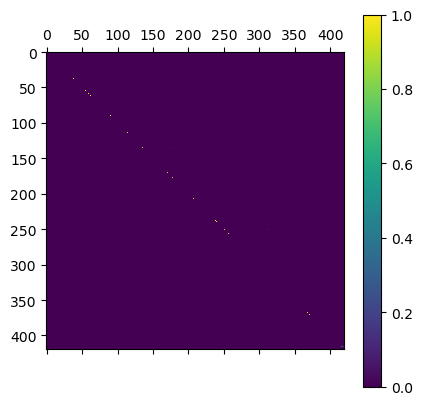

  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | 

In [16]:
results[2].evaluate = MultiLevelResultCollector.evaluate
results[2].evaluate(results[2])

In [31]:
llw = model.classifier.linear._parameters["weight"].data.clone()

llw -= llw.mean(dim = 1, keepdim=True)
llw /= llw.std(dim = 1, unbiased=True, keepdim=True)
llwn = llw.norm(2, dim=1)


cos_mat = (llw @ llw.T) / (llwn.unsqueeze(0) * llwn.unsqueeze(1))
eucl_mat = torch.cdist(llw, llw)

plt.matshow(torch.distributions.Chi2(llw.shape[1]).cdf((eucl_mat.cpu() ** 2 / 2)).fill_diagonal_(torch.nan))
plt.colorbar()
# plt.savefig("weight_cor.png")
plt.show()
# plt.close()

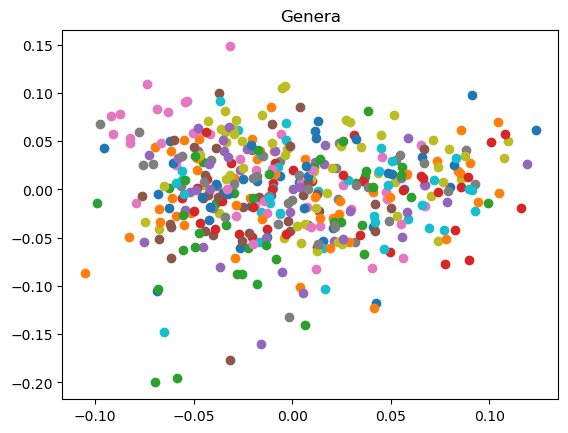

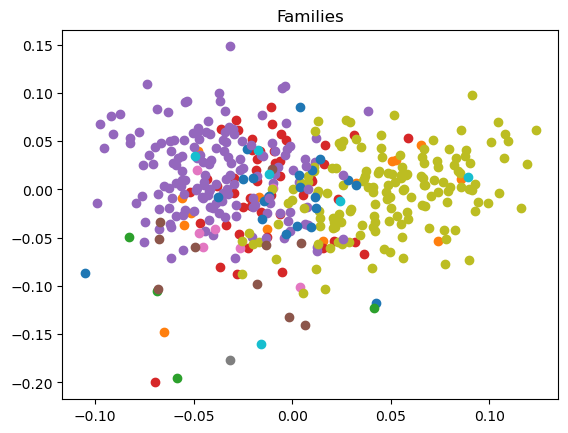

In [189]:
pxy = torch.pca_lowrank(llw.float(), 2, niter=100)[0].cpu()
gns = [row.nonzero().flatten().long() for row in (class_info[0]["masks"][0] + 100)]
fns = [row.nonzero().flatten().long() for row in (((class_info[0]["masks"][0] + 100)/100).T @ ((class_info[0]["masks"][1] + 100)/100).T).T]
for gn in gns:
    gpxy = pxy[gn]
    plt.scatter(*gpxy.T)
plt.title("Genera")
plt.show()
for fn in fns:
    fpxy = pxy[fn]
    plt.scatter(*fpxy.T)
plt.title("Families")
plt.show()


In [149]:
import sys
from importlib import util
from types import ModuleType
from pathlib import Path

def import_module_from_folder(folder: str, module_name: str, package_name: str = None):
    """
    Dynamically imports a module from a folder that uses relative imports.

    :param folder: Path to the project folder (must contain __init__.py).
    :param module_name: Name of the .py file (without .py) to import.
    :param package_name: Package name to assign (defaults to folder name).
    :return: The imported module.
    """
    folder = Path(folder).resolve()
    pkg_name = package_name or folder.name

    # 1) Create and register the package
    pkg = ModuleType(pkg_name)
    pkg.__path__ = [str(folder)]
    sys.modules[pkg_name] = pkg

    # 2) Build spec for the submodule
    full_mod_name = f"{pkg_name}.{module_name}"
    file_path = folder / f"{module_name}.py"
    spec = util.spec_from_file_location(full_mod_name, str(file_path))

    # 3) Create, register, and execute the module
    mod = util.module_from_spec(spec)
    sys.modules[full_mod_name] = mod
    spec.loader.exec_module(mod)

    return mod

m = import_module_from_folder("/home/asger/structured-analysis", "plots")

m.hierarchical_cluster_llw(model.classifier.linear._parameters["weight"].data.clone().cpu(), list(cls2idx[2]))

[169,
 170,
 68,
 70,
 69,
 118,
 125,
 131,
 129,
 126,
 134,
 130,
 133,
 136,
 175,
 128,
 127,
 132,
 159,
 182,
 81,
 82,
 79,
 168,
 9,
 10,
 7,
 11,
 228,
 67,
 269,
 72,
 386,
 397,
 77,
 221,
 327,
 23,
 21,
 22,
 205,
 112,
 116,
 117,
 392,
 393,
 390,
 388,
 389,
 178,
 142,
 143,
 95,
 155,
 187,
 394,
 395,
 176,
 74,
 75,
 165,
 113,
 289,
 184,
 87,
 183,
 101,
 102,
 103,
 51,
 13,
 14,
 57,
 160,
 189,
 204,
 73,
 108,
 162,
 186,
 78,
 32,
 33,
 120,
 123,
 121,
 124,
 137,
 152,
 153,
 147,
 192,
 36,
 34,
 35,
 39,
 38,
 54,
 139,
 140,
 201,
 202,
 177,
 203,
 93,
 206,
 209,
 210,
 208,
 114,
 115,
 89,
 119,
 180,
 179,
 181,
 161,
 163,
 164,
 76,
 196,
 266,
 104,
 105,
 396,
 215,
 216,
 3,
 4,
 55,
 60,
 47,
 44,
 45,
 146,
 144,
 150,
 194,
 145,
 148,
 149,
 151,
 71,
 96,
 174,
 200,
 376,
 374,
 375,
 173,
 24,
 52,
 377,
 283,
 290,
 172,
 191,
 195,
 80,
 83,
 41,
 58,
 59,
 157,
 158,
 84,
 85,
 190,
 193,
 380,
 381,
 26,
 37,
 248,
 207,
 106,
 122,